In [1]:


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf

from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score

In [2]:
base_directory = 'Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [3]:
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [4]:
img_dim = 256

In [5]:
def input_target_split(data,images_folder,masks_folder,dim):
    dataset = []
    for index, row in data.iterrows():
        image = load_img(os.path.join(images_folder, row['image']), target_size=(dim,dim)) 
        mask = load_img(os.path.join(masks_folder, row['mask']), target_size=(dim,dim), color_mode='grayscale')
        image = img_to_array(image)
        image = image/255.0
        mask = img_to_array(mask)
        mask = mask/255.0
        dataset.append((image,mask))
        print(f"\rProgress: {index}",end='')
    random.shuffle(dataset)
    X, Y = zip(*dataset)

    return np.array(X),np.array(Y)
    

In [6]:
X, Y = input_target_split(data,images_folder,masks_folder,img_dim)

Progress: 5107

In [7]:
print("Image Dimensions: ",X.shape)
print("Mask Dimensions: ",Y.shape)

Image Dimensions:  (5108, 256, 256, 3)
Mask Dimensions:  (5108, 256, 256, 1)


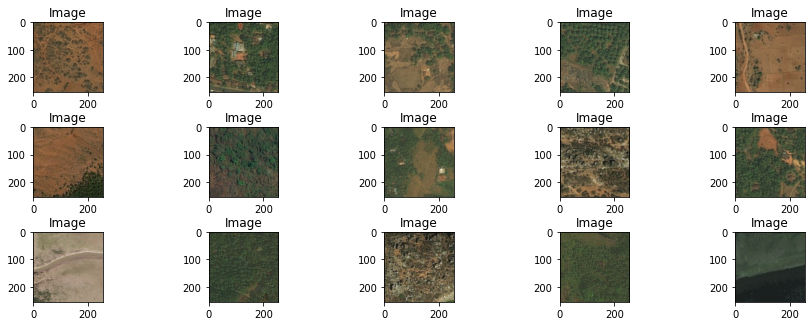

In [8]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title('Image')

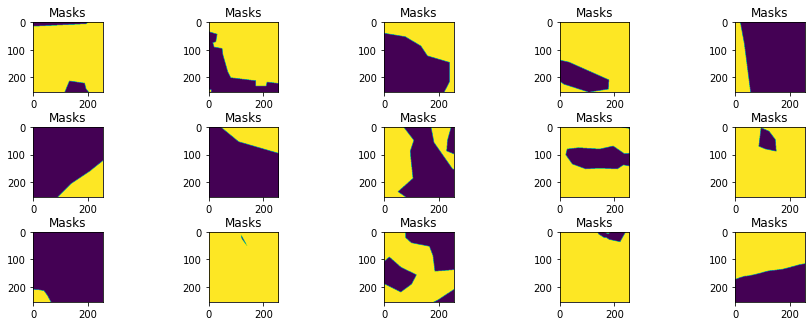

In [9]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Y[i])
    plt.title('Masks')

In [10]:
split = round(X.shape[0]*0.80)
X_train1 = X[:split]
Y_train1 = Y[:split]
X_test1 = X[split:]
Y_test1 = Y[split:]

In [11]:
datagen = ImageDataGenerator()
testgen = ImageDataGenerator()

In [12]:
datagen.fit(X_train1)
testgen.fit(X_test1)

In [13]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [14]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

   
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

   
    union = area_true + area_pred - intersection

   
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

   
    iou = intersection / union

    
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   
        false_positives = np.sum(matches, axis=0) == 0  
        false_negatives = np.sum(matches, axis=1) == 0  
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [15]:
input_shape = (img_dim, img_dim, 3)
model1 = build_unet(input_shape)
model1.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
model1.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])

C:\Users\Aravind\AppData\Roaming\Python\Python36\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
model_path = "vnet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)
ac=[]

In [18]:
from lib.utils import *
from sklearn.model_selection import train_test_split
X,y=Image_generator(X_train1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
def train(opt, device):
    init_seeds(opt.seed + 1 + RANK, deterministic=True)
    save_dir, data, bs, epochs, nw, imgsz, pretrained = \
        opt.save_dir, Path(opt.data), opt.batch_size, opt.epochs, min(os.cpu_count() - 1, opt.workers), \
        opt.imgsz, str(opt.pretrained).lower() == 'true'
    cuda = device.type != 'cpu'

   
    wdir = save_dir / 'weights'
    wdir.mkdir(parents=True, exist_ok=True)  
    last, best = wdir / 'last.pt', wdir / 'best.pt'

    
    yaml_save(save_dir / 'opt.yaml', vars(opt))

    
    logger = GenericLogger(opt=opt, console_logger=LOGGER) if RANK in {-1, 0} else None

    
    with torch_distributed_zero_first(LOCAL_RANK), WorkingDirectory(ROOT):
        data_dir = data if data.is_dir() else (DATASETS_DIR / data)
        if not data_dir.is_dir():
            LOGGER.info(f'\nDataset not found ⚠️, missing path {data_dir}, attempting download...')
            t = time.time()
            if str(data) == 'imagenet':
                subprocess.run(f"bash {ROOT / 'data/scripts/get_imagenet.sh'}", shell=True, check=True)
            else:
               
                download(url, dir=data_dir.parent)
            s = f"Dataset download success ({time.time() - t:.1f}s), saved to {colorstr('bold', data_dir)}\n"
            LOGGER.info(s)

    
    nc = len([x for x in (data_dir / 'train').glob('*') if x.is_dir()])  # number of classes
    trainloader = create_classification_dataloader(path=data_dir / 'train',
                                                   imgsz=imgsz,
                                                   batch_size=bs // WORLD_SIZE,
                                                   augment=True,
                                                   cache=opt.cache,
                                                   rank=LOCAL_RANK,
                                                   workers=nw)

    test_dir = data_dir / 'test' if (data_dir / 'test').exists() else data_dir / 'val'  # data/test or data/val
    if RANK in {-1, 0}:
        testloader = create_classification_dataloader(path=test_dir,
                                                      imgsz=imgsz,
                                                      batch_size=bs // WORLD_SIZE * 2,
                                                      augment=False,
                                                      cache=opt.cache,
                                                      rank=-1,
                                                      workers=nw)

    # Model
    with torch_distributed_zero_first(LOCAL_RANK), WorkingDirectory(ROOT):
        if Path(opt.model).is_file() or opt.model.endswith('.pt'):
            model = attempt_load(opt.model, device='cpu', fuse=False)
        elif opt.model in torchvision.models.__dict__:  
            model = torchvision.models.__dict__[opt.model](weights='IMAGENET1K_V1' if pretrained else None)
        else:
            m = hub.list('ultralytics/yolov5')  
            raise ModuleNotFoundError(f'--model {opt.model} not found. Available models are: \n' + '\n'.join(m))
        if isinstance(model, DetectionModel):
            LOGGER.warning("WARNING ⚠️ pass YOLOv5 classifier model with '-cls' suffix, i.e. '--model yolov5s-cls.pt'")
            model = ClassificationModel(model=model, nc=nc, cutoff=opt.cutoff or 10)  #
        reshape_classifier_output(model, nc)  
    for m in model.modules():
        if not pretrained and hasattr(m, 'reset_parameters'):
            m.reset_parameters()
        if isinstance(m, torch.nn.Dropout) and opt.dropout is not None:
            m.p = opt.dropout  
    for p in model.parameters():
        p.requires_grad = True  
    model = model.to(device)

    # Info
    if RANK in {-1, 0}:
        model.names = trainloader.dataset.classes  
        model.transforms = testloader.dataset.torch_transforms  
        model_info(model)
        if opt.verbose:
            LOGGER.info(model)
        images, labels = next(iter(trainloader))
        file = imshow_cls(images[:25], labels[:25], names=model.names, f=save_dir / 'train_images.jpg')
        logger.log_images(file, name='Train Examples')
        logger.log_graph(model, imgsz)  
    
    optimizer = smart_optimizer(model, opt.optimizer, opt.lr0, momentum=0.9, decay=opt.decay)

    
    lrf = 0.01  
    
    lf = lambda x: (1 - x / epochs) * (1 - lrf) + lrf  
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
  


    ema = ModelEMA(model) if RANK in {-1, 0} else None
    

from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=5)
ac.append(accuracy_score(model,y_test,sample_weight=0.2)*100)

Epoch 1/5
4/4 [==============================] - 1s 2ms/step - loss: 0.3851
Epoch 2/5
4/4 [==============================] - 0s 3ms/step - loss: 0.3224
Epoch 3/5
4/4 [==============================] - 0s 2ms/step - loss: 0.2568
Epoch 4/5
4/4 [==============================] - 0s 2ms/step - loss: 0.1946
Epoch 5/5
4/4 [==============================] - 0s 3ms/step - loss: 0.1342


In [20]:
from sklearn.neural_network import MLPClassifier 
model1 = MLPClassifier(random_state=1, max_iter=300)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
ac.append(accuracy_score(model1,y_test,sample_weight=0.4)*100)

C:\Users\Aravind\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:

TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [22]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Aravind\AppData\Local\Temp\tmpjjnd55l1\assets


In [23]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

1628

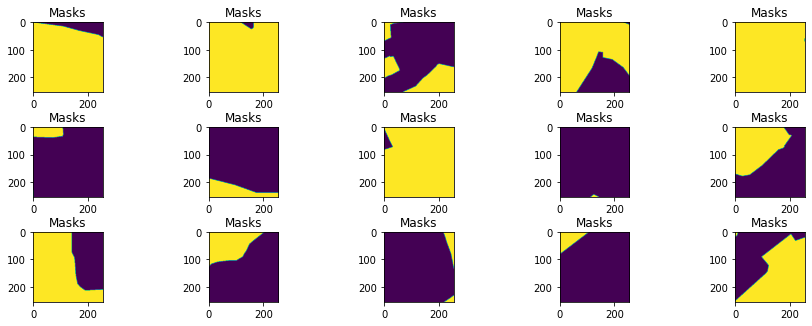

In [24]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(0,15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Y_test1[i])
    plt.title('Masks')

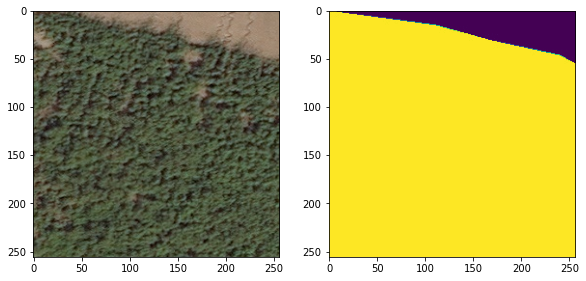

In [25]:
plt.figure(figsize = (15 , 9))

#result = model.predict(X_test1[:50])
#output = result[0]
#output[output >= 0.5] = 1
#output[output < 0.5] = 0

plt.subplot(1, 3, 1)
plt.imshow(X_test1[0])

plt.subplot(1, 3, 2)
plt.imshow(Y_test1[0])



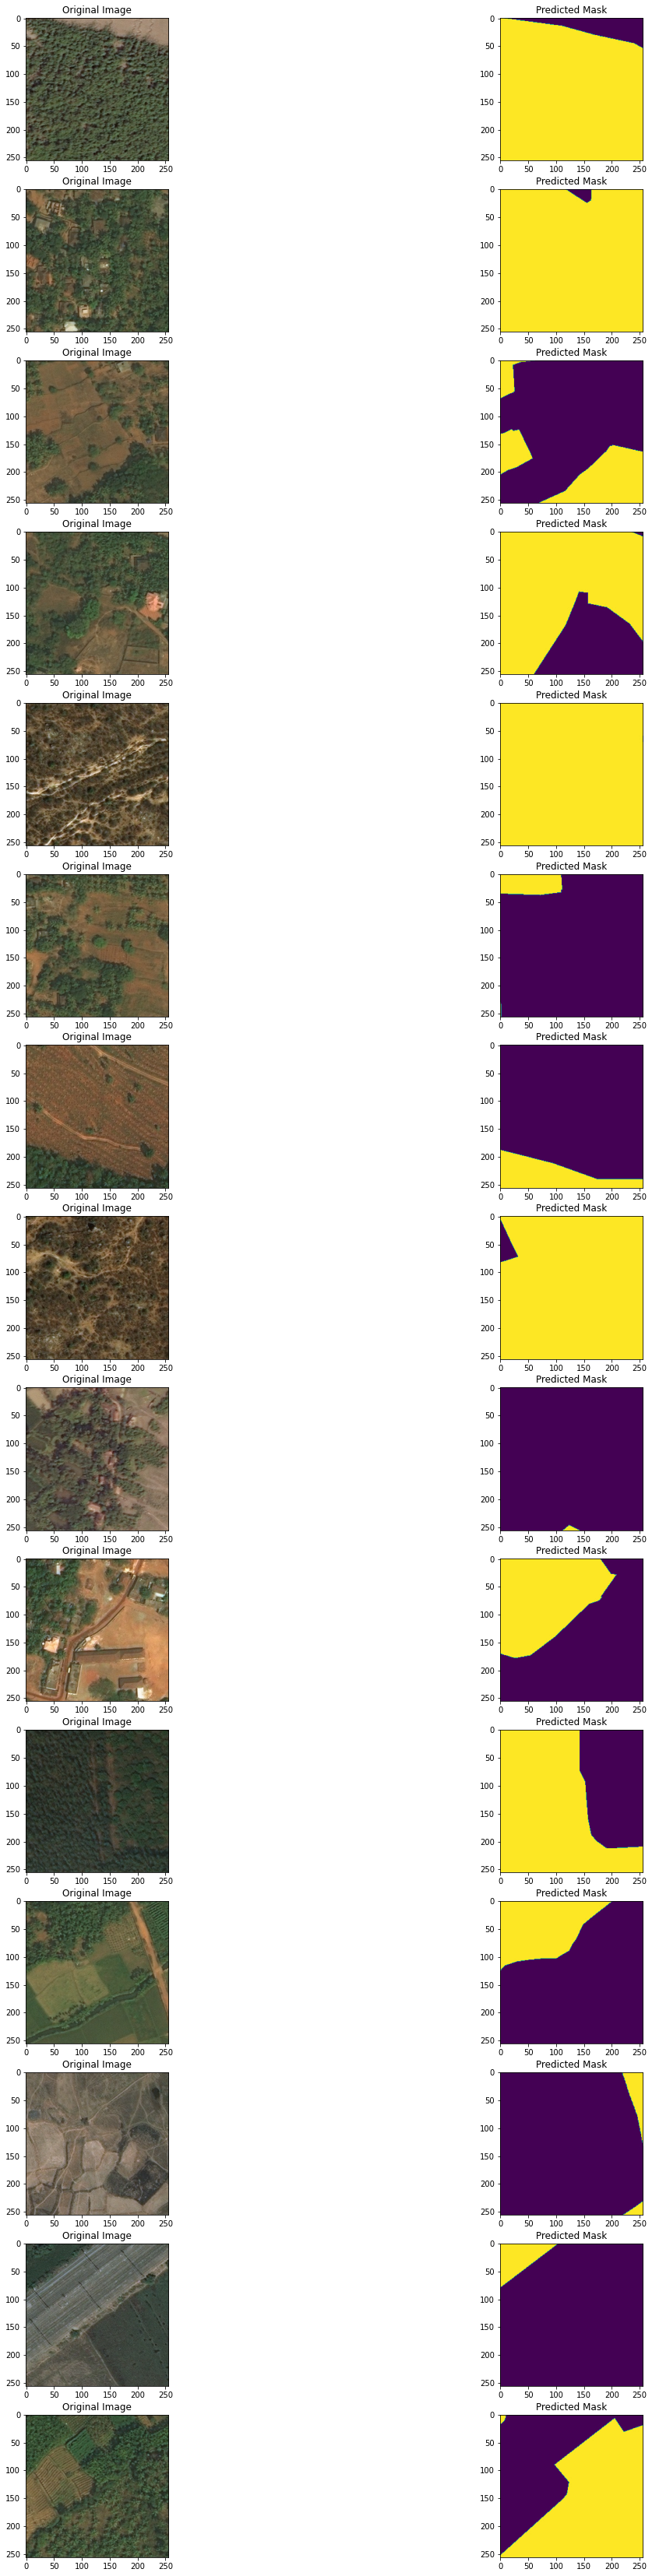

In [26]:
f, axarr = plt.subplots(15,2,figsize=(20, 60))

for i in range(0,15):
  
 

    axarr[i,0].imshow(X_test1[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,1].imshow(Y_test1[i])
    axarr[i,1].title.set_text('Predicted Mask')
   

the accuracy of Yolo v5 is 95.7 and MLP is 92.9


C:\Users\Aravind\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(50.0, 100.0)

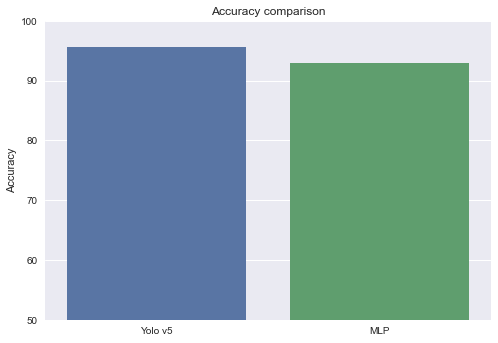

In [27]:

import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('seaborn')
x=['Yolo v5','MLP']
 
ax=sns.barplot(x,ac[:2])
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)